In [1]:
import pandas as pd
import gzip
import numpy as np

# Reading Dataset


In [2]:
def get_images(path):
    with gzip.open(path, 'r') as f:
        # first 4 bytes is a magic number
        magic_number = int.from_bytes(f.read(4), 'big')
        # second 4 bytes is the number of images
        image_count = int.from_bytes(f.read(4), 'big')
        # third 4 bytes is the row count
        row_count = int.from_bytes(f.read(4), 'big')
        # fourth 4 bytes is the column count
        column_count = int.from_bytes(f.read(4), 'big')
        # rest is the image pixel data, each pixel is stored as an unsigned byte
        # pixel values are 0 to 255
        image_data = f.read()
        images = np.frombuffer(image_data, dtype=np.uint8)\
            .reshape((image_count, row_count, column_count))
        return images


def get_labels(path):
    with gzip.open(path, 'r') as f:
        # first 4 bytes is a magic number
        magic_number = int.from_bytes(f.read(4), 'big')
        # second 4 bytes is the number of labels
        label_count = int.from_bytes(f.read(4), 'big')
        # rest is the label data, each label is stored as unsigned byte
        # label values are 0 to 9
        label_data = f.read()
        labels = np.frombuffer(label_data, dtype=np.uint8)
        return labels
    
def display(display_list):
    plt.figure(figsize=(15, 15))
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()


In [3]:
# Train Test Paths
train_imagesPath = 'dataset/train-images-idx3-ubyte.gz'
train_labelsPath = 'dataset/train-labels-idx1-ubyte.gz'
test_imagesPath  = 'dataset/t10k-images-idx3-ubyte.gz'
test_label_path  = 'dataset/train-labels-idx1-ubyte.gz'

X_train, y_train = get_images(train_imagesPath), get_labels(train_labelsPath)
X_test, y_test = get_images(test_imagesPath), get_labels(test_label_path)


print(f"Training Images :{X_train.shape} Training Labels : {y_train.shape}")

Training Images :(60000, 28, 28) Training Labels : (60000,)


# Question No 1
    1. Scan all possible locations for object
        So we have image of 28 * 28 we make paths of 5 * 5 from every image. 

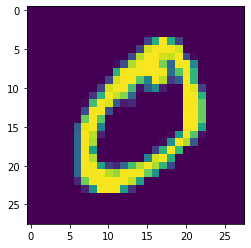

In [4]:
import matplotlib.pyplot as plt
plt.imshow(X_train[1])
plt.show()

### Slicing Image with sliding window concept

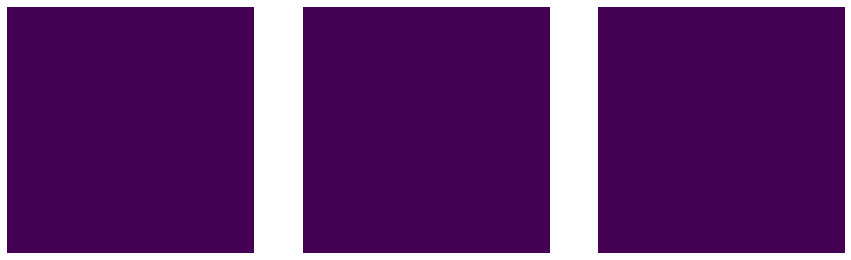

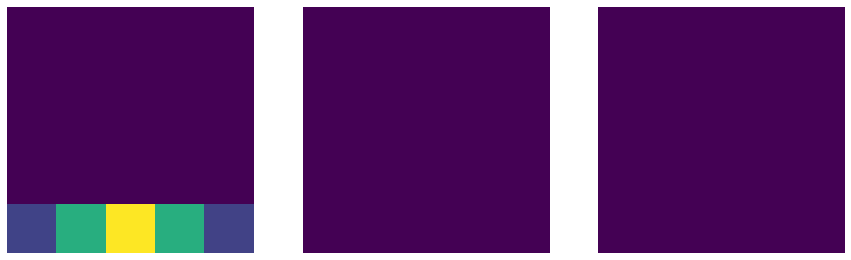

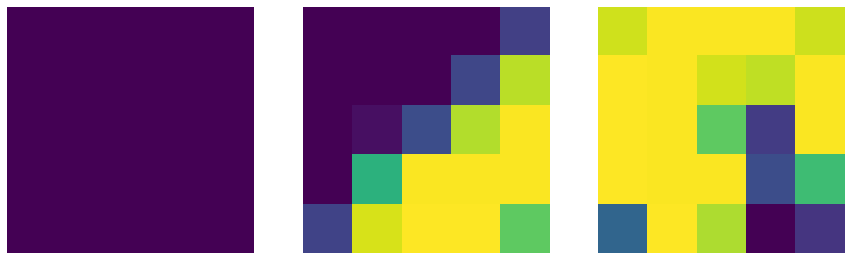

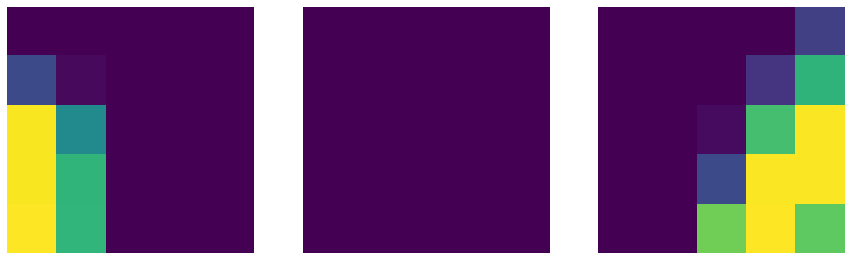

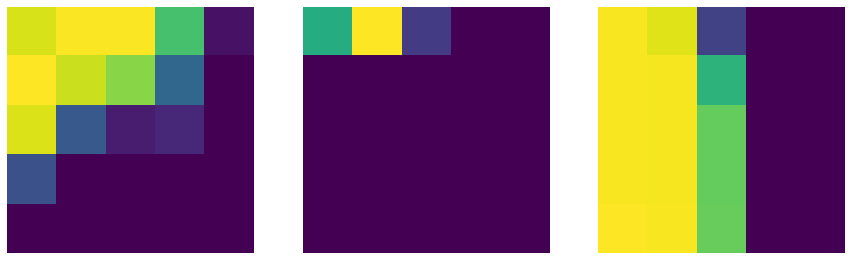

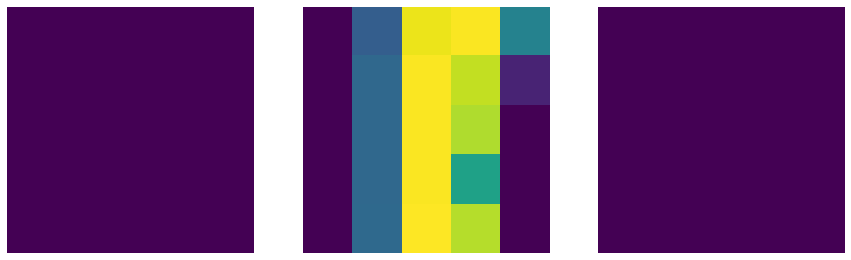

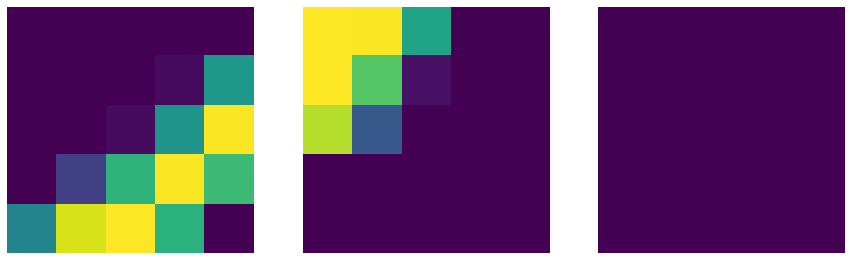

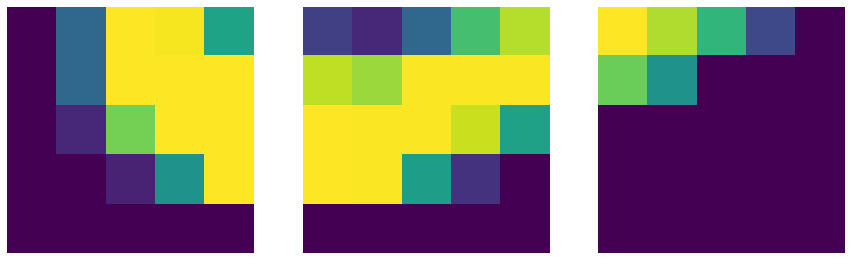

In [5]:
def make_patches(image, patch_size = 5):
    '''
    Description:
        This fucnction will help you out to get the patches of the image of shape (patch_size * patch_size)
        
    Input:
        image       (nd-array): Numpy array of the image
        patch_size  (int)     : Integer which defines your patch size
    
    Output:
        patches     (list)    : List of patches
    '''
    height, width = image.shape 
    patches       = []

    for i in range(0, height, patch_size):
        for j in range(0, width, patch_size):
            patch = image[i:i+patch_size, j:j+patch_size]

            p_h, p_w = patch.shape
            if (p_h == patch_size) and (p_w == patch_size):
                patches.append(patch)
    return patches
            
patch_size    = 5 
image         = X_train[1]
patches = make_patches(image, patch_size)

for i in range(0, len(patches), 3):
    try:
        display([patches[i], patches[i+1] , patches[i+2]])
    except:
        pass

### HogFeatures

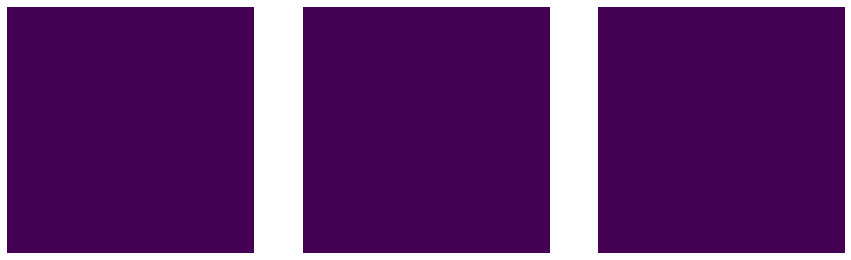

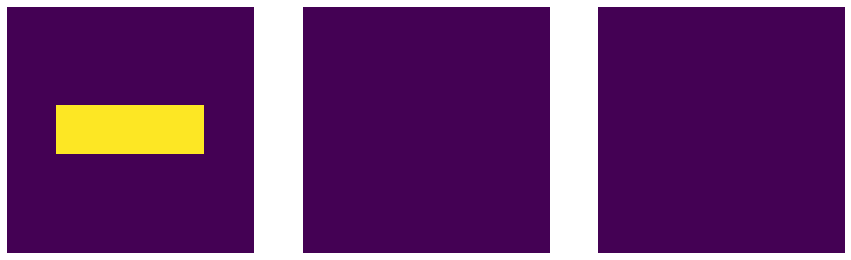

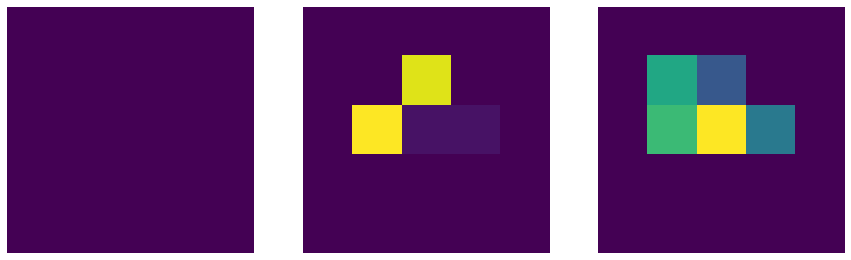

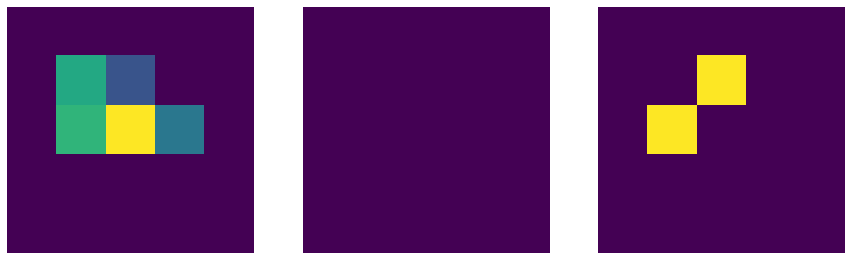

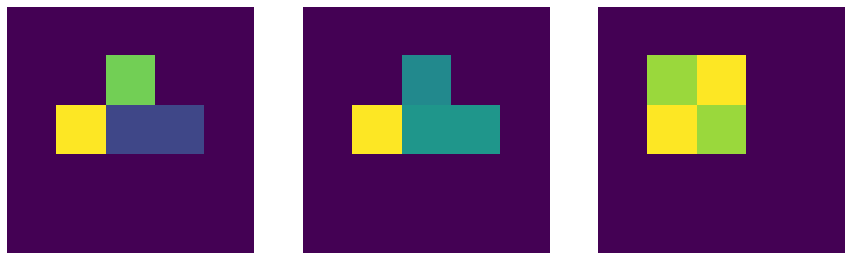

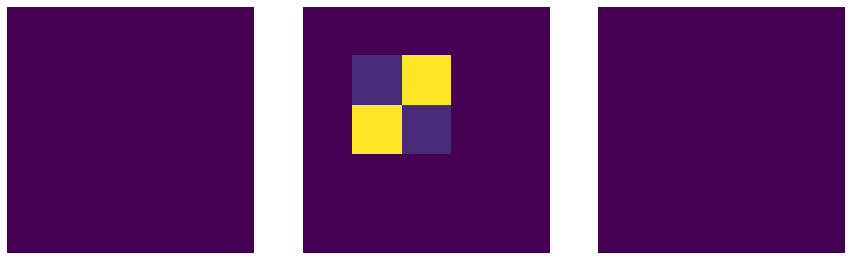

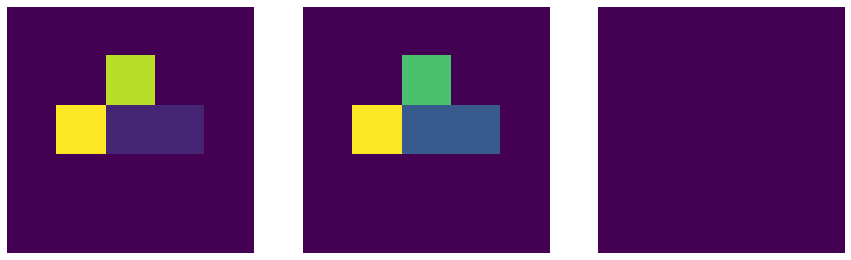

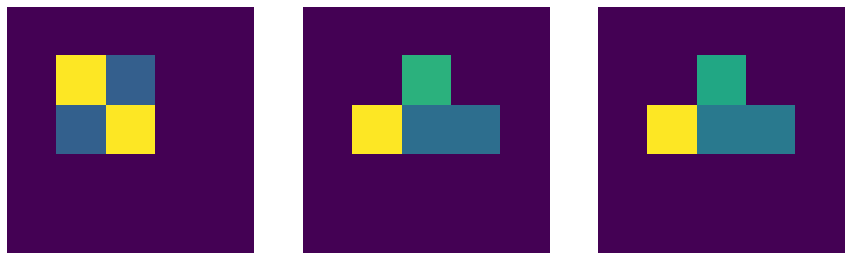

In [6]:
# HOG Feature (Histogram of Gradients)
from skimage.feature import hog

def hog_feature(image):
    '''
    Description:
        This fucntion will help you out in getting the hog feature of the image
        
    Input:
        image  (nd-array) : Numpy array of the image
        
    Output:
        features (nd=array) : hog Features of the image
    
    '''
    fd, hog_image = hog(image, orientations=9, pixels_per_cell=(5, 5),
                	cells_per_block=(2, 2), visualize=True, multichannel=False)
    return hog_image



hog_features = []
for i in range(0, len(patches)):
    try:
        #creating hog features
        hog_image = hog_feature(patches[i])
        hog_features.append(hog_image)
    except:
        pass

    
for i in range(0, len(hog_features), 3):
    try:
        display([hog_features[i], hog_features[i+1] , hog_features[i+2]])
    except:
        pass

### SIFT Features

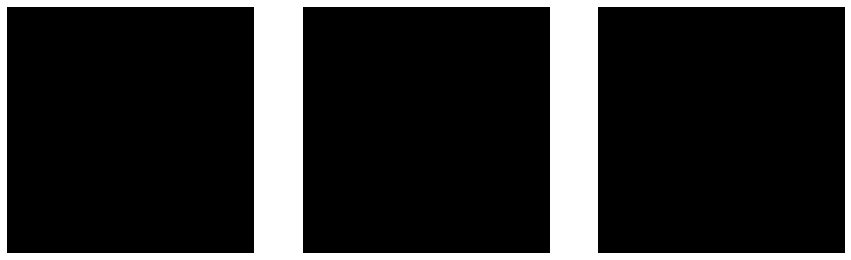

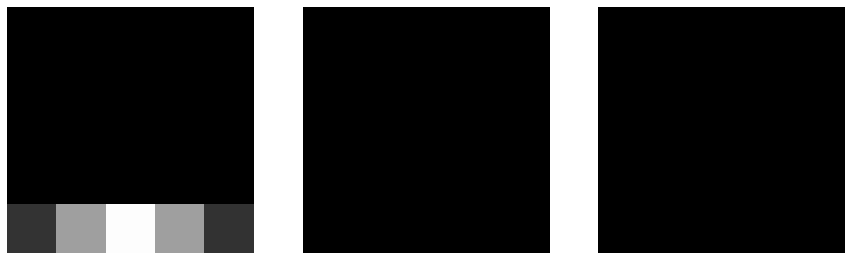

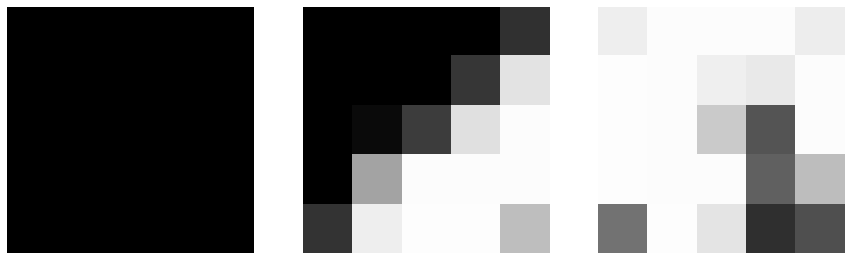

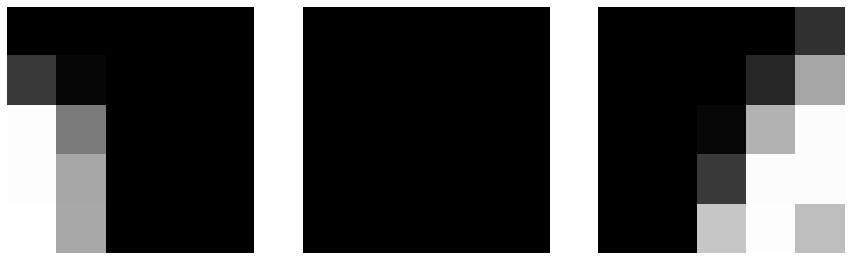

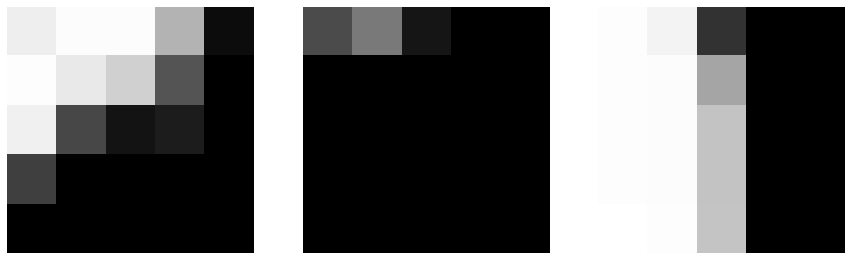

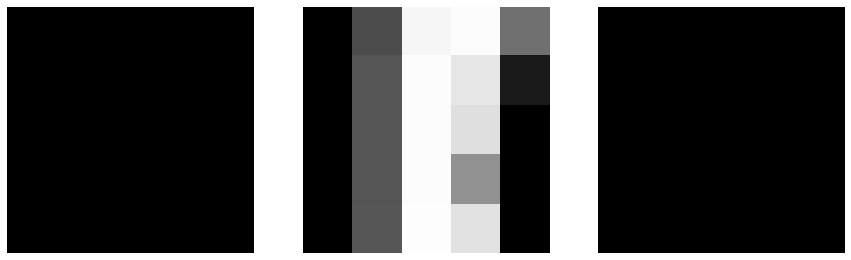

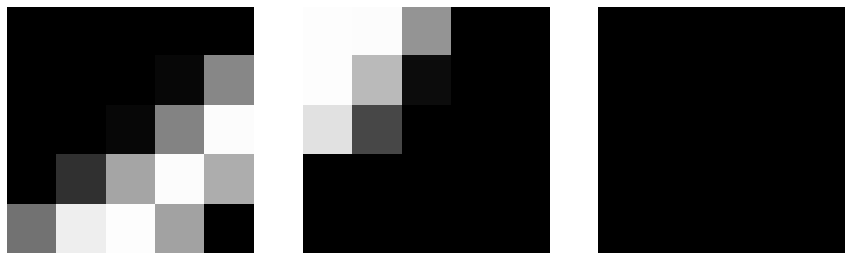

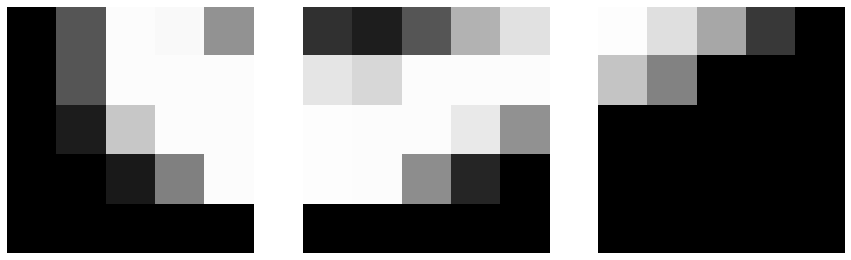

In [7]:
# Install this open-cv version if you get erros
#pip install -U opencv-contrib-python==3.4.2.16 -y

import cv2
sift = cv2.xfeatures2d.SIFT_create()

def sift_feature(image):
    '''
    Description:
        This fucntion will help you out in getting the sift feature of the image
        
    Input:
        image  (nd-array) : Numpy array of the image
        
    Output:
        features (nd=array) : sift Features of the image
    
    '''
    keypoints_sift, descriptors = sift.detectAndCompute(image, None)
    
    return keypoints_sift


sift_features = []
for i in range(0, len(patches)):
    #creating hog features
    image = patches[i]
    keypoints_sift = sift_feature(image)
    img = cv2.drawKeypoints(image, keypoints_sift, None)
    sift_features.append(img)
    
    


for i in range(0, len(sift_features), 3):
    try:
        display([sift_features[i], sift_features[i+1] , sift_features[i+2]])
    except:
        pass


# Making Dataset for Classification
    I am using mnist so its easy to seperate the patches which has any object and patches with no objects
    

In [11]:
import random
import os
from PIL import Image
objects     = "dataset/dataset_objects_not_objects/objects/"
not_objects = "dataset/dataset_objects_not_objects/not_objects/"

os.system(f"mkdir -p {objects}")
os.system(f"mkdir -p {not_objects}")

count_objects, count_notobjects = 0, 0
num =10000

for i in X_train:
    patches = make_patches(i, patch_size = 5)
    for i in range(0, len(patches)):
        sum_patch = np.sum(patches[i])

        if sum_patch == 0 and count_objects <= num:
            save_path = f"{not_objects}_patch_{i}_{int(random.random() * 100000)}.jpg"
            count_objects += 1
            plt.imsave(save_path,patches[i])

        elif sum_patch != 0 and count_notobjects <= num:
            save_path = f"{objects}_patch_{i}_{int(random.random() * 100000)}.jpg"
            count_notobjects += 1
            plt.imsave(save_path,patches[i])
        
        if count_objects == num and count_notobjects ==num:
            break
        
        
        

# Question no 3

    Classification Part I will use many classifiers to get the best one out of it.
    

In [20]:
import glob
objects_paths     = glob.glob(objects+"/*.*g")
not_objects_paths = glob.glob(not_objects+"/*.*g")


def take_features(i):
    img = cv2.imread(i, 0)
    sift_featuers = sift_feature(img)
    hog_features  = hog_feature(img)
    features = np.append(sift_featuers, hog_features).flatten()
    return features

X, y = [], []
for i in objects_paths:
    X.append(take_features(i))
    y.append(1)
    
for i in not_objects_paths:
    X.append(take_features(i))
    y.append(0)
    
X = np.asarray(X)
y = np.asarray(y)

# Stacking Almost 22 algorithms to get the best results

In [23]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import  VotingClassifier
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import metrics
from sklearn import ensemble
from sklearn import gaussian_process
from sklearn import linear_model
from sklearn import naive_bayes
from sklearn import neighbors
from sklearn import svm
from sklearn import tree
from sklearn import discriminant_analysis
from sklearn import model_selection
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory


In [ ]:

MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),   
    ]




#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters', 'MLA Test Accuracy' ]
MLA_compare = pd.DataFrame(columns = MLA_columns)

X_train, X_test, y_train, y_test = train_test_split(
   X,y, test_size=0.1, random_state=0)

#index through MLA and save performance to table
row_index = 0
for alg in MLA:

    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
   # cv_results = model_selection.cross_validate(alg, X_train, y_train)
    alg.fit(X_train, y_train)
    y_pred=alg.predict(X_test)
    score=metrics.accuracy_score(y_test, y_pred)
    
    MLA_compare.loc[row_index, 'MLA Test Accuracy'] =score
    print(f"MLA_name {MLA_name} Score {score}")
    
    
    row_index+=1

    

MLA_compare
#MLA_predict

MLA_name AdaBoostClassifier Score 1.0
MLA_name BaggingClassifier Score 1.0
MLA_name ExtraTreesClassifier Score 1.0
MLA_name GradientBoostingClassifier Score 1.0
MLA_name RandomForestClassifier Score 1.0


# AS Seen through the test results we are already gettting 100% accuracy
# No post processing needs